## This notebook considers size of image = 1024. 
Includes kfold cross validation and gradient clipping.
Exp 1 : 2 folds and lr = 9e-4. Freezed : 7, unfreezed : 12 steps Loss: mixedloss (Dice Loss + Focal Loss (gama = 1.0)) 

In [1]:
import fastai
from fastai.vision import *
from mask_functions import *
from fastai.callbacks import SaveModelCallback
import gc
from sklearn.model_selection import KFold
from PIL import Image

fastai.__version__

'1.0.52'

In [2]:
sz = 1024
bs = 2
n_acc = 64//bs #gradinet accumulation steps
nfolds = 2
SEED = 2019

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

stats = ([0.5213,0.5218,0.5213],[0.254,0.254,0.254])
TRAIN = 'dataset/1024/train/'
TEST = 'dataset/1024/test/'
MASKS = 'dataset/1024/masks/'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)

seed_everything(SEED)

In [3]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [4]:
def set_BN_momentum(model,momentum=0.1*bs/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [ ]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [ ]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)


In [ ]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    preds, ys = learn.get_preds(ds_type)
    preds = preds[:,1,...]
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = learn.get_preds(ds_type)
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    del preds_lr
    gc.collect()
    torch.cuda.empty_cache()
    return preds, ys

In [ ]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

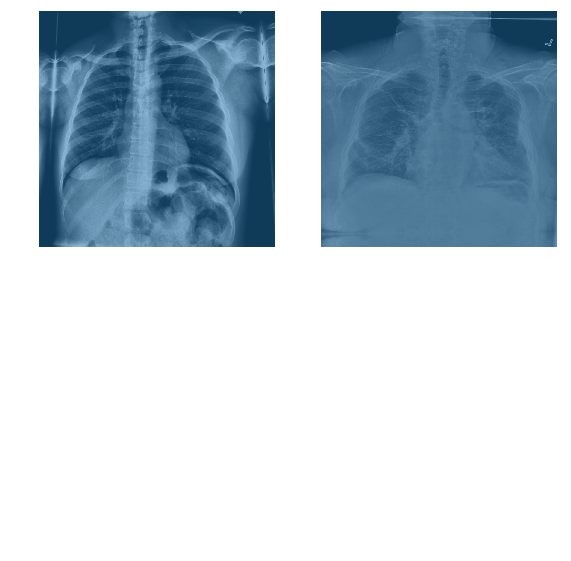

In [ ]:
def get_data(fold):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    valid_idx = list(kf.split(list(range(len(Path(TRAIN).ls())))))[fold][1]
    # Create databunch
    data = (SegmentationItemList.from_folder(TRAIN)
            .split_by_idx(valid_idx)
            .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

In [ ]:
# import torch
# from torch import nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.logits = logits
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         if self.logits:
#             BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         else:
#             BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction is None:
#             return F_loss
#         else:
#             return torch.mean(F_loss)

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
unet_learner(get_data(0), models.resnet34, metrics=[dice]).summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 512, 512]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 512, 512]       128        True      
______________________________________________________________________
ReLU                 [64, 512, 512]       0          False     
______________________________________________________________________
MaxPool2d            [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [64, 256, 256]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________

In [ ]:
# unet_learner(get_data(0), models.resnet34, metrics=[dice]).model.loss_fn

In [ ]:
scores, best_thrs = [],[]

for fold in range(nfolds):
    print('fold: ', fold)
    data = get_data(fold)
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    #learn.load('fold_4')
    learn.loss = MixedLoss(0.25, 1.7)
    learn.opt_fn = optim.Adam
    learn.clip_grad(1.0)
    set_BN_momentum(learn.model)
    
    #fit the decoder part of the model keeping the encode frozen
    lr = 1e-4
    #learn.load('fold_4')
    learn.fit_one_cycle(7, lr, callbacks = [AccumulateStep(learn,n_acc)])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(12, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])
    learn.save('1024_fold_'+str(fold));
    
    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
    pt, _ = pred_with_flip(learn,DatasetType.Test)
    
    if fold == 0: preds_test = pt
    else: preds_test += pt
        
    #convert predictions to byte type and save
    preds_save = (preds*255.0).byte()
    torch.save(preds_save, '1024_preds_fold'+str(fold)+'.pt')
    np.save('1024_items_fold'+str(fold), data.valid_ds.items)
        
    #remove noise
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0

    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    dices = []
    thrs = np.arange(0.01, 1, 0.01)
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        dices.append(dice_overall(preds_m, ys).mean())
    dices = np.array(dices)    
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])
     
    if fold != nfolds-1: del preds, ys, preds_save
    gc.collect()
    torch.cuda.empty_cache()
    
preds_test /= nfolds

fold:  0


epoch,train_loss,valid_loss,dice,time


In [ ]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

In [ ]:
best_dice = dices.max()
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

In [ ]:
#convert predictions to byte type and save
preds_save = (preds_test*255.0).byte()
torch.save(preds_save, 'preds_test_1024_focal_loss.pt')

preds_test[preds_test.view(preds_test.shape[0],-1).sum(-1) < noise_th,...] = 0.0

In [ ]:
preds_test = (preds_test>best_thr).long().numpy()
rles = []
for p in progress_bar(preds_test):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [ ]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.to_csv('submission.csv', index=False)
sub_df.head()